In [1]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [18]:
%load_ext autoreload
%autoreload 2
import cProfile
from datetime import datetime
import importlib
import numpy as np
import os
import yaml
from generator import MCTS
from language import Language
from node import MolSentenceNode
from utils import add_sep, class_from_package, make_logger

config_path = "config/mcts_d_score_replication.yaml"
with open(os.path.join(repo_root, config_path)) as f:
    conf = yaml.safe_load(f)

output_dir=os.path.join(repo_root, "sandbox", conf["output_dir"], datetime.now().strftime("%m-%d_%H-%M")) + os.sep
logger = make_logger(output_dir)

transition_class, transition_conf, device, lang_path = (conf.get(k) for k in ("transition_class", "transition_conf", "device", "lang_path"))
if "model_dir" in transition_conf:
    transition_conf["model_dir"] = os.path.join(repo_root, transition_conf["model_dir"])
if lang_path is None:
    lang_name = os.path.basename(os.path.normpath(transition_conf["model_dir"])) + ".lang"
    lang_path = add_sep(transition_conf["model_dir"]) + lang_name
lang = Language.load(lang_path, device=device)
transition_class = class_from_package("transition", transition_class)
transition = transition_class(lang=lang, logger=logger, **transition_conf)

reward_class = class_from_package("reward", conf.get("reward_class"))
reward = reward_class(**conf.get("reward_conf", {}))
policy_class = class_from_package("policy", conf.get("policy_class"))
policy = policy_class(**conf.get("policy_conf", {}))

filter_settings = conf.get("filters", [])
filters = []
for s in filter_settings:
    filter_class = class_from_package("filter", s.pop("filter_class"))
    filters.append(filter_class(**s))

Is CUDA available: False


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Starting search...
1- time: 0.00, reward: 0.344002577254424, node: CN(C(=O)COc1ccc(F)cc1)S(=O)(=O)c1ccccc1
2- time: 0.00, reward: 0.0, node: C#Cc1ccc(NC(=O)[C@H](C)C(=O)[O-])cc1
3- time: 0.30, reward: 0.3879279161084677, node: O=C(N[C@@H]1CC[NH+](CCc2ncn(-c3ccccc3)n2)C1)c1ccccc1
4- time: 0.30, reward: 0.33122952321931776, node: O=C(NCCC1CCCC1)NCc1nc2cnccc2[nH]1
5- time: 0.30, reward: 0.45797016453951944, node: O=C(N[C@H]1CCOC1)c1ccnc(-c2cnc3nnnn3c2)c1
6- time: 0.60, reward: 0.3730075573975019, node: N#Cc1ccccc1OCC(=O)NCC1CCCC1
7- time: 0.60, reward: 0.0, node: NS(=O)(=O)c1ccc(/C=C/c2cccnc2Br)cc1
8- time: 0.84, reward: 0.3183334588094466, node: Fc1cc(N2CCN(Cc3ccc(F)cc3)CC2)ccn1
9- time: 1.08, reward: 0.4089984491275953, node: [NH3+][C@H]1CCCC(O)(c2ccccc2F)C1
10- time: 1.08, reward: 0.0, node: [NH3+][C@@H]([C@H]1CN1C(=O)[C@H](c1ccccc1)c1ccc(Cl)s1)C1CC1
11- time: 1.32, reward: 0.34665727889515524, node: c1ccc(OCC(=O)NC[C@H](O)c2cc(Cl)c(Cl)cc2)cc1
12- time: 1.57, reward: 0.3731832040210339

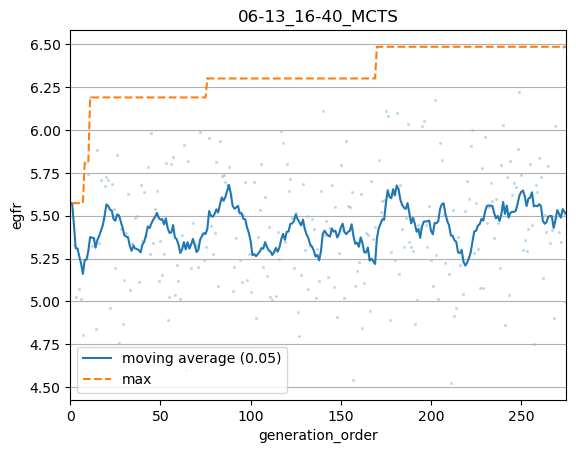

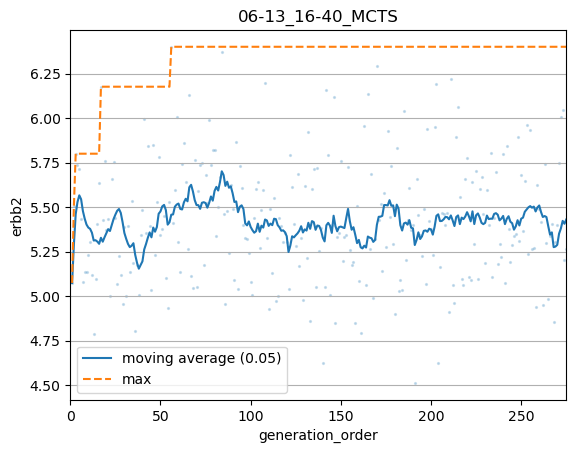

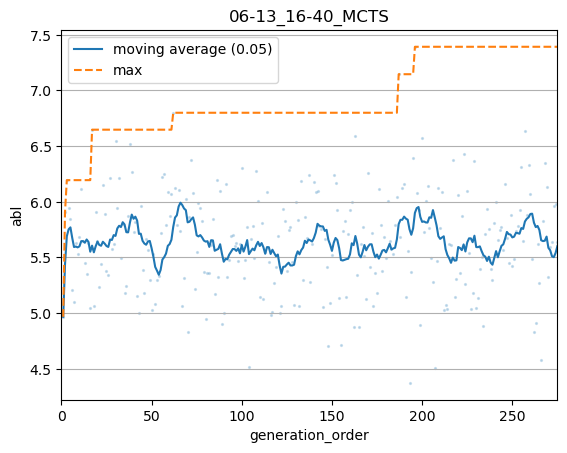

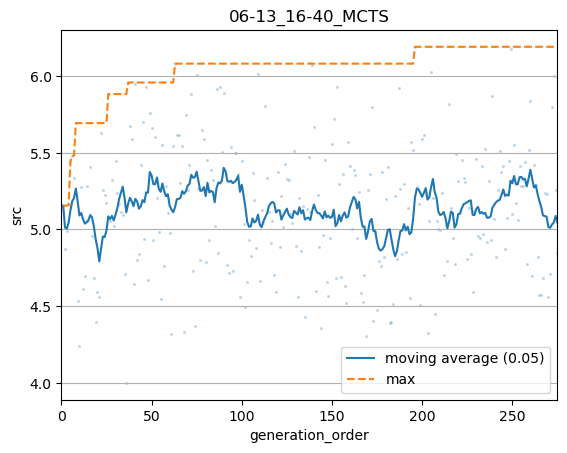

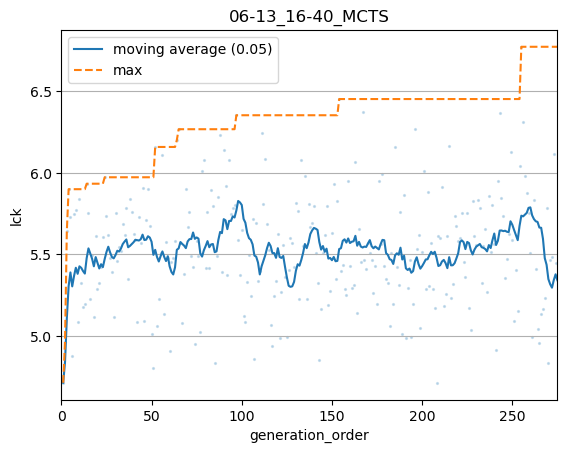

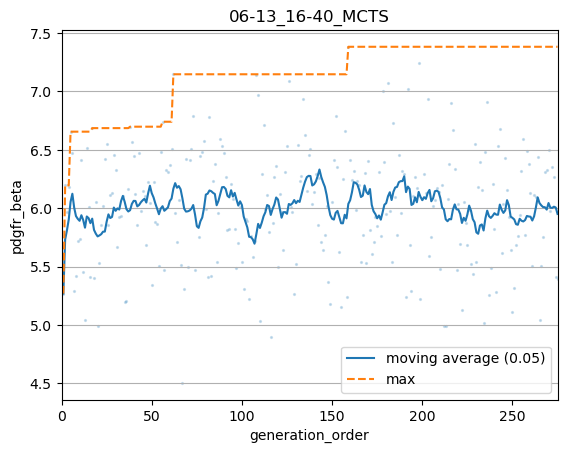

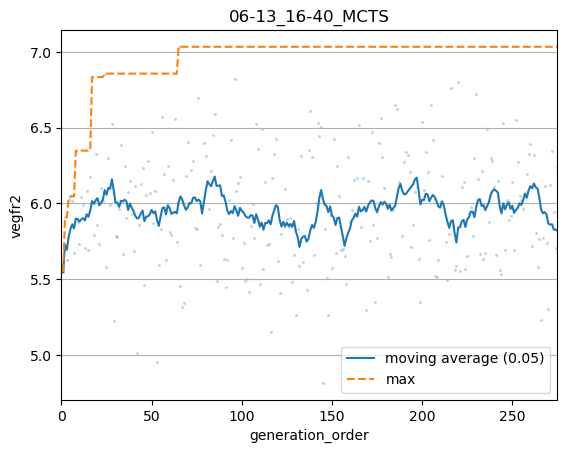

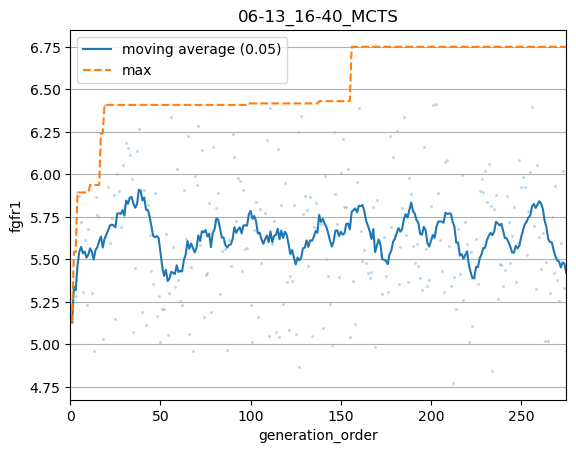

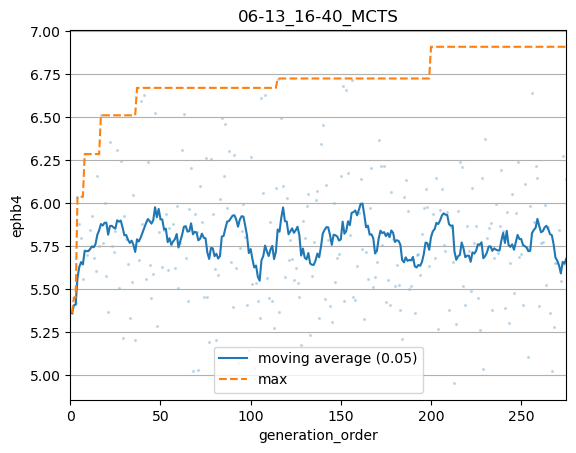

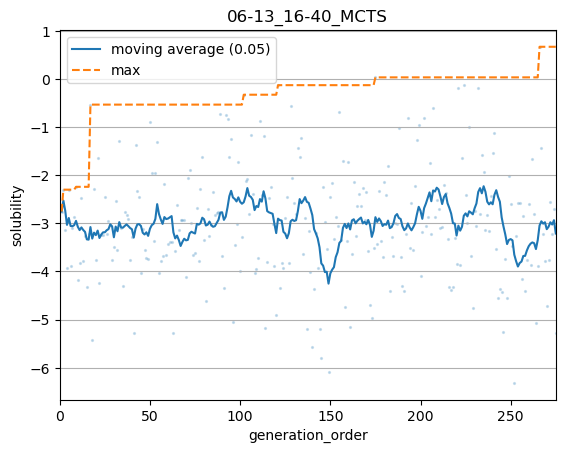

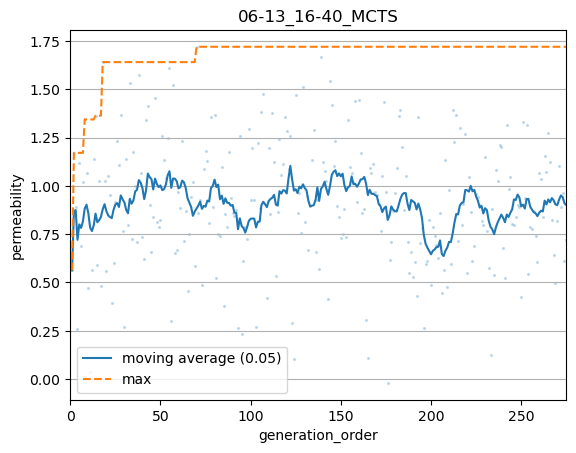

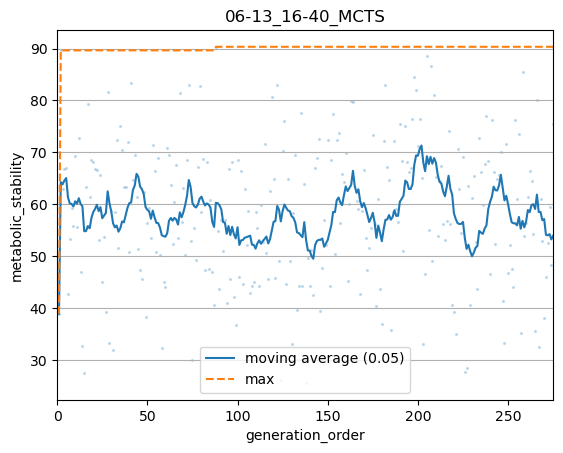

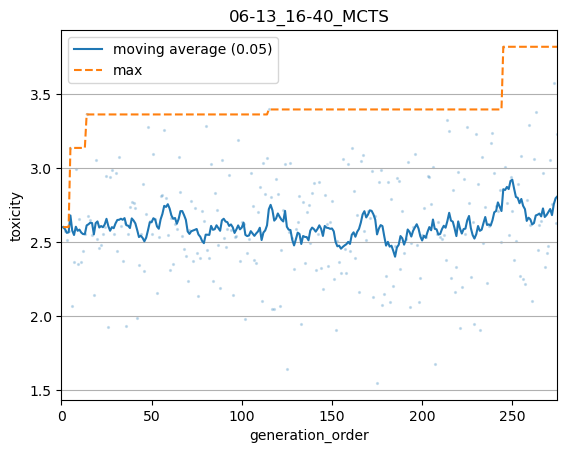

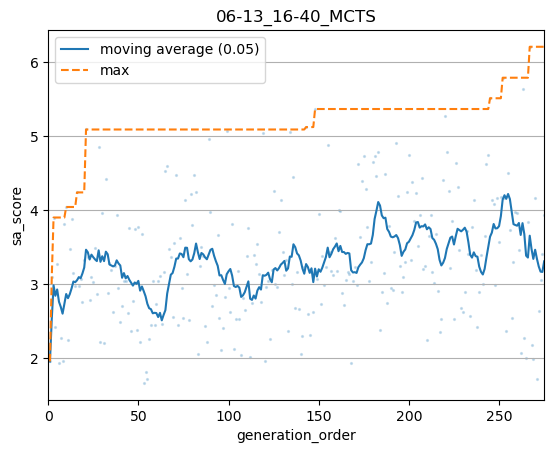

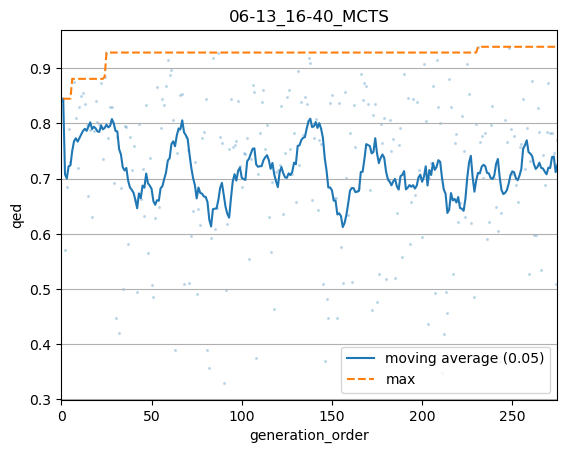

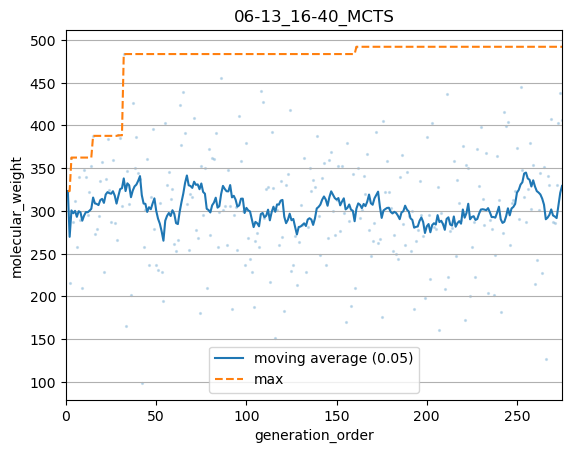

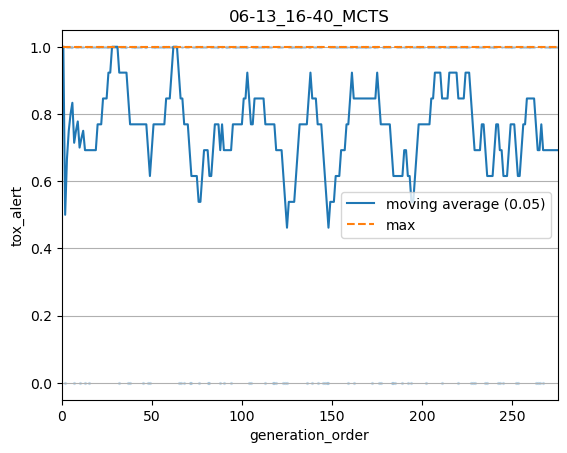

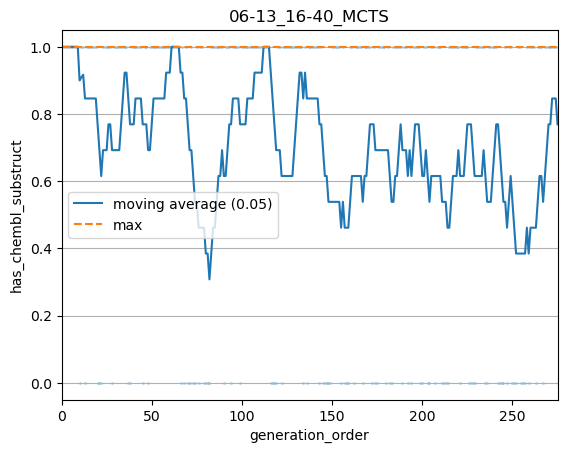

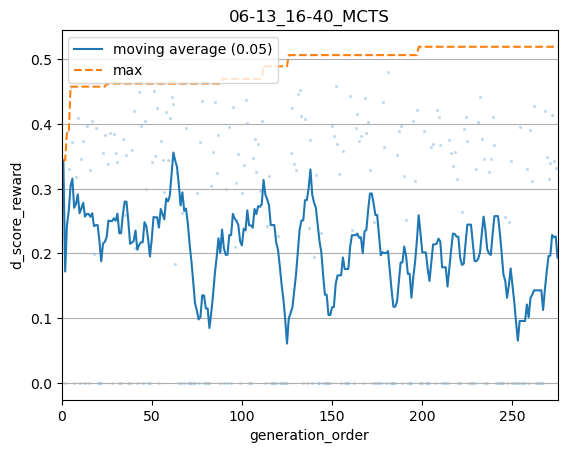

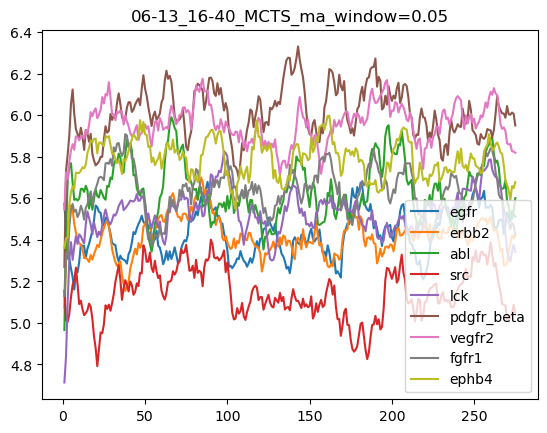

number of generated nodes: 275
valid rate: 0.3884180790960452
node_per_sec: 4.5751270803295885


In [20]:
from rdkit import RDLogger
import shutil

RDLogger.DisableLog('rdApp.*') # invalid mols are already logged

root = MolSentenceNode.bos_node(lang) # TODO: change after root node generalization

generator = MCTS(root=root, transition=transition, reward=reward, policy=policy, filters=filters, filtered_reward=conf.get("filtered_reward"), output_dir=output_dir, logger=logger, **conf.get("generator_conf"))
src = os.path.join(repo_root, config_path)
dst = os.path.join(output_dir, "setting.yaml")
shutil.copy(src, dst)

generator.generate(time_limit=conf.get("time_limit"), max_generations=conf.get("max_generations"))
# cProfile.run("generator.generate(root=root, **generation_conf)"")
generator.plot(**conf.get("plot_conf", {}))
generator.analyze()

In [ ]:
#continue search
generator.generate(max_generations=10)
generator.plot(**conf.get("plot_conf", {}))
generator.analyze()

In [ ]:
#save mcts
save_path = generator.output_dir() + "save.mcts"
generator.save(save_path)

In [ ]:
#load mcts
load_path = os.path.join(output_dir, "06-09_22-15_MCTS_PUCT/test.mcts")
generator = MCTS.load(load_path, transition)